# CS440 Final Project - Fall 2024
# Huberman on Exercise

## Team Members
- **Miguel Rosales**
- **Gabriel Schoncher**
- **Thomas McRoskey**

### See README.md for more information


# Setup and Initial Data Handling

## Hyperparameters

In [62]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

batch_size = 32 # number of sequences in a batch, processed in parallel
block_size = 32 # length of a sequence, max context length for predictions (time steps)
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32 # 32 dimensional embedding. This is the size of the "input" to each transformer layer
# head_size = 16
seed = 47
n_layers = 4  # --> 4 transformer layers (num blocks)
n_heads = 4   # --> 4 attention heads in each transformer layer
dropout = 0.2 # --> prevents overfitting by randomly 'dropping out' some of the data (cuts communication between tokens)

## Import the data 

In [63]:
import pandas as pd

df = pd.read_parquet("hf://datasets/dexaai/huberman_on_exercise/data/data-00000-of-00001-8e5e40fbf9236004.parquet")
df.head()

,id,embedding,metadata,document
0,chunk_57169,"[-0.03923165, -0.0016832227, 0.014283108, -0.0...","{'chunkTitle': 'Muscle Hypertrophy', 'episodeT...",Andrew Huberman: And that leads me to a questi...
1,chunk_57178,"[-0.02918509, -0.018408643, 0.017951787, -0.03...",{'chunkTitle': 'Hypertrophy Training Overview'...,Andrew Huberman: So as you point out before an...
2,chunk_57177,"[-0.030115174, -0.01321885, 0.02527428, -0.005...","{'chunkTitle': 'Fitness and Hypertrophy', 'epi...",Andy Galpin: Sure. So we have a lot less infor...
3,chunk_57176,"[-0.028269125, 0.006626837, 0.022055835, -0.00...","{'chunkTitle': 'Cardio and Hypertrophy', 'epis...",Andrew Huberman: How do other forms of exercis...
4,chunk_57175,"[-0.025013695, 0.00445241, 0.029148076, -0.009...","{'chunkTitle': 'Indicators and Adjustments', '...",Andy Galpin: You could also look at things lik...


## Preprocess Data

Preprocess the documents in the dataset at the character level and structure it in a way that is suitable for the model.

### Clean data

The embedding column contains the weight of the word in the document. We will remove this column since we are not using it.

Dexa.ai has their own vocabulary, and we don't know what that is. So it's best to come up with our own.

In [64]:
# Num embeddings and first 10 embeddings
# NOTE: We believe that dexa used sub-word tokenization, so the embeddings are not char embeddings like ours
# Which is why they have a different length to the document
print(len(df['embedding'][0]))
print(df['embedding'][0][:10])

# Num characters in document and first 10 characters
print(len(df['document'][0]))
print(df['document'][0][:10])

1536
[-0.03923165 -0.00168322  0.01428311 -0.01472527 -0.0111009  -0.00633093
  0.00908438 -0.02190702 -0.02619463 -0.01615894]
2974
Andrew Hub


In [65]:
# Remove Second Column (Embedding)
df = df.drop(columns=['embedding'])

df.head()

,id,metadata,document
0,chunk_57169,"{'chunkTitle': 'Muscle Hypertrophy', 'episodeT...",Andrew Huberman: And that leads me to a questi...
1,chunk_57178,{'chunkTitle': 'Hypertrophy Training Overview'...,Andrew Huberman: So as you point out before an...
2,chunk_57177,"{'chunkTitle': 'Fitness and Hypertrophy', 'epi...",Andy Galpin: Sure. So we have a lot less infor...
3,chunk_57176,"{'chunkTitle': 'Cardio and Hypertrophy', 'epis...",Andrew Huberman: How do other forms of exercis...
4,chunk_57175,"{'chunkTitle': 'Indicators and Adjustments', '...",Andy Galpin: You could also look at things lik...


In [66]:
# This are different ways to preprocess the text
# Uncomment to see the effect of each one

import re

# Remove all non-alphanumeric characters and lowercase
# df['document'] = df['document'].apply(lambda x: re.sub(r'\W+', ' ', x).lower())

# Remove punctuation (keeps numbers and capitalization)
# df['document'] = df['document'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Remove numbers and lowercase everything
# df['document'] = df['document'].apply(lambda x: re.sub(r'\d+', '', x).lower())

df.head()

,id,metadata,document
0,chunk_57169,"{'chunkTitle': 'Muscle Hypertrophy', 'episodeT...",Andrew Huberman: And that leads me to a questi...
1,chunk_57178,{'chunkTitle': 'Hypertrophy Training Overview'...,Andrew Huberman: So as you point out before an...
2,chunk_57177,"{'chunkTitle': 'Fitness and Hypertrophy', 'epi...",Andy Galpin: Sure. So we have a lot less infor...
3,chunk_57176,"{'chunkTitle': 'Cardio and Hypertrophy', 'epis...",Andrew Huberman: How do other forms of exercis...
4,chunk_57175,"{'chunkTitle': 'Indicators and Adjustments', '...",Andy Galpin: You could also look at things lik...


### Tokenize Data

In [67]:
# Convert to list in order to combine all documents into one list
corpus = df['document'].tolist()
# print(type(corpus))
print(len(corpus))  # The number of documents
corpus[:5]          # The first 5 documents

293


["Andrew Huberman: And that leads me to a question that is based on findings that I've heard discussed on social media, which means very little, if anything, unless it's in the context of people who really know exercise science. And you're one such person. And that's this idea that because resistance training can evoke a protein synthesis adaptation response, but that adaptation response lasts about 48 hours before it starts to taper off. That the ideal. In quotes, frequency for training a given muscle group for hypertrophy is about every 48 hours. Is that true?\n\nAndy Galpin: Yes and no. So a couple of things there remember, in order to grow a muscle, there's multiple steps here. So you have the signaling response, which actually happens within seconds of exercise and can last, depending on the marker, up to an hour or 2 hours. Step number two then is gene expression, and we see that that's typically peaked around two to 6 hours post exercise. And then you have following that protein

In [68]:
# Convert list to string by joining all documents
text = ' '.join(corpus)
# print(text[:1000])
print(len(text))   # The number of chars in the corpus
print(text[:100])  # First 100 characters of the corpus
# print(type(text))

812479
Andrew Huberman: And that leads me to a question that is based on findings that I've heard discussed


### Build Vocabulary for Model

The vocab will be broken down to the character level and word level.
We decided to break down the vocab to the character level and word level because they seemed like the simplest approach. Also to see if which can get better results.

#### Character Level

In [69]:
# Create a list of all unique characters in the text
vocab = sorted(list(set(text)))
v_size = len(vocab)

print("Vocabulary Size: ", v_size)             # The number of unique characters in the text
print("Vocabulary in text: ", ''.join(vocab))  # The unique characters in the text

Vocabulary Size:  76
Vocabulary in text:  
 "$%',-./0123456789:?@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz£


#### Word Level

In [70]:
vocab_words = list(set(text.split()))
v_size_words = len(vocab_words)

print("Vocabulary Size: ", v_size_words)              # The number of unique words in the text
print("Vocabulary in text: ", ' '.join(vocab_words))  # The unique words in the text

Vocabulary Size:  11672
Vocabulary in text:  forth, book Adrenergic dopamine recreational influencing three, Or gun thousand. Prize. switching, ish issue upgrading citation resistant. tailor blocked class, dividing supplies repair, Azetamib increment. starting, much provided assisted unable Richard Whereas sufficiently recording innervate periodization being slow. whose mini easier challenging. feel. packed Mash impaired Clomophine matter, counterintuitive complicated, come disclaimer, sure dipping unmeasurable. table, vitamins isolating Levels extent, level, salivary, excitement. tape, professionals, miraculously, deficiency sign. physiologists mitochondrial meditation McMillan consistently. yours. normally, tips conscious. guaranteed Fitness, accurate, pharma development. preseason, fasting stressful. steroids, empirically. built snatches separately. approaches annually them glean pertains consider incredibly Nothing's decency superb. Here's relates address the tension. 20%. practice

### Text Vectorization

Text vectorization is the process of converting tokens into numerical representations. So each value in the vocab will be assigned a unique integer value (an index).
In industry, the most common way to tokenize text is through a sub-word vocabulary. Google uses SentencePiece to tokenize their data. OpenAI uses the TikToken library to tokenize their data. We didn't use either of these approaches because it is more complex and we wanted to keep things simple.

Link to SentencePiece: https://github.com/google/sentencepiece

Link to TikToken: https://github.com/openai/tiktoken?tab=readme-ov-file


#### Character Level

In [71]:
# Map each character to an index
stoi = {c: i for i, c in enumerate(vocab)}  # This converts a character to an index
itos = {i: c for i, c in enumerate(vocab)}  # This converts an index to a character
encode = lambda x: [stoi[c] for c in x] # encode('m') -> 0, takes a character and returns its index in the vocabulary
decode = lambda s: ''.join(itos[i] for i in s) # decode([0, 1, 2]) -> 'abc', takes a list of indices and returns the corresponding string

# Converting the text to a list of indices, and vice versa
print('Encoded:', encode("Andrew Huberman"))
print('Decoded:', decode(encode("Andrew Huberman")))

Encoded: [23, 62, 52, 66, 53, 71, 1, 30, 69, 50, 53, 66, 61, 49, 62]
Decoded: Andrew Huberman


#### Word Level

In [72]:
# Map each word to an index
wtoi = {w: i for i, w in enumerate(vocab_words)}  # This converts a word to an index
itow = {i: w for i, w in enumerate(vocab_words)}  # This converts an index to a word
encode_word = lambda x: [wtoi[w] for w in x.split()] # encode('miguel') -> 0, takes a character and returns its index in the vocabulary
decode_word = lambda s: ' '.join(itow[i] for i in s) # decode([0, 1, 2]) -> 'miguel is cool', takes a list of indices and returns the corresponding string

print('Encoded:', encode_word("Andrew Huberman"))
print('Decoded:', decode_word(encode_word("Andrew Huberman")))

Encoded: [1091, 7870]
Decoded: Andrew Huberman


In [73]:
# Encode the entire text
import torch

# NOTE: Depending on which encoding you use, you will need to toggle the commented lines below and at the end of cells #90 and #93 (the model initialization and v_size input)
# and in #95 (when decoding)

data = torch.tensor(encode(text), dtype=torch.long)    # Character encoding
# data = torch.tensor(encode_word(text), dtype=torch.long) # Word encoding
print(data.shape, data.type())
print(data[:100])  # The first 100 characters in the text as their index in the vocabulary


torch.Size([812479]) torch.LongTensor
tensor([23, 62, 52, 66, 53, 71,  1, 30, 69, 50, 53, 66, 61, 49, 62, 20,  1, 23,
        62, 52,  1, 68, 56, 49, 68,  1, 60, 53, 49, 52, 67,  1, 61, 53,  1, 68,
        63,  1, 49,  1, 65, 69, 53, 67, 68, 57, 63, 62,  1, 68, 56, 49, 68,  1,
        57, 67,  1, 50, 49, 67, 53, 52,  1, 63, 62,  1, 54, 57, 62, 52, 57, 62,
        55, 67,  1, 68, 56, 49, 68,  1, 31,  5, 70, 53,  1, 56, 53, 49, 66, 52,
         1, 52, 57, 67, 51, 69, 67, 67, 53, 52])


# Split Data to Train and Validation Sets

In [74]:
# Split into training and validation sets
train_size = int(0.9 * len(data))
train_data = data[:train_size]
val_data = data[train_size:]
print('Train size:', len(train_data))
print('Val size:', len(val_data))

Train size: 731231
Val size: 81248


Data will be trained per block size, meaning that the model only has a context of a certain number of characters.

In [75]:
print(block_size)
train_data[:block_size + 1]  # +1 because the target is the next character

32


tensor([23, 62, 52, 66, 53, 71,  1, 30, 69, 50, 53, 66, 61, 49, 62, 20,  1, 23,
        62, 52,  1, 68, 56, 49, 68,  1, 60, 53, 49, 52, 67,  1, 61])

In [76]:
# This is to show how the data will make predictions
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t + 1]
    target = y[t]
    print(f"when input is {context} the target is {target}")

when input is tensor([23]) the target is 62
when input is tensor([23, 62]) the target is 52
when input is tensor([23, 62, 52]) the target is 66
when input is tensor([23, 62, 52, 66]) the target is 53
when input is tensor([23, 62, 52, 66, 53]) the target is 71
when input is tensor([23, 62, 52, 66, 53, 71]) the target is 1
when input is tensor([23, 62, 52, 66, 53, 71,  1]) the target is 30
when input is tensor([23, 62, 52, 66, 53, 71,  1, 30]) the target is 69
when input is tensor([23, 62, 52, 66, 53, 71,  1, 30, 69]) the target is 50
when input is tensor([23, 62, 52, 66, 53, 71,  1, 30, 69, 50]) the target is 53
when input is tensor([23, 62, 52, 66, 53, 71,  1, 30, 69, 50, 53]) the target is 66
when input is tensor([23, 62, 52, 66, 53, 71,  1, 30, 69, 50, 53, 66]) the target is 61
when input is tensor([23, 62, 52, 66, 53, 71,  1, 30, 69, 50, 53, 66, 61]) the target is 49
when input is tensor([23, 62, 52, 66, 53, 71,  1, 30, 69, 50, 53, 66, 61, 49]) the target is 62
when input is tensor(

In [77]:
torch.manual_seed(seed)
import numpy as np

# our data loader function
def get_batch(split):
    # data array encoded as integers
    data = train_data if split == 'train' else val_data
    
    # This gives 'batch_size' number of random indices to start each sequence
    ix = torch.randint(0, len(data) - block_size, (batch_size,))
    
    # This stacks the sequences in a batch, (batch_size, block_size)
    x = torch.stack([data[i:i + block_size] for i in ix])
    y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Averages loss over multiple batches
# Why do this? Less noisy and more stable gradients. Meaning the model will learn better
@torch.no_grad()  # -> let's PyTorch know that we don't need to keep track of gradients (back propagation) for this function
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out
        

# xb is the input sequence, yb is the target
xb, yb = get_batch('train')
print('Inputs: ', xb.shape)
print(xb)
print('Targets: ', yb.shape)
print(yb)

print('------')

# This is to show how the data will make predictions in parallel with batches
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t + 1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target is {target}")
    


Inputs:  torch.Size([32, 32])
tensor([[53, 68, 53,  ..., 57, 51, 53],
        [53, 73,  1,  ..., 70, 53,  1],
        [ 8,  1, 31,  ..., 68,  1, 50],
        ...,
        [ 1, 66, 53,  ..., 68, 63, 68],
        [ 8,  1, 23,  ..., 53,  1, 66],
        [63, 69,  5,  ...,  1, 49, 62]])
Targets:  torch.Size([32, 32])
tensor([[68, 53, 60,  ..., 51, 53,  6],
        [73,  1, 49,  ..., 53,  1, 49],
        [ 1, 31,  1,  ...,  1, 50, 53],
        ...,
        [66, 53, 64,  ..., 63, 68, 49],
        [ 1, 23, 62,  ...,  1, 66, 53],
        [69,  5, 66,  ..., 49, 62, 52]])
------
when input is [53] the target is 68
when input is [53, 68] the target is 53
when input is [53, 68, 53] the target is 60
when input is [53, 68, 53, 60] the target is 73
when input is [53, 68, 53, 60, 73] the target is 1
when input is [53, 68, 53, 60, 73, 1] the target is 52
when input is [53, 68, 53, 60, 73, 1, 52] the target is 57
when input is [53, 68, 53, 60, 73, 1, 52, 57] the target is 54
when input is [53, 68, 53, 6

# Model & Architecture

Our implementation for our 'Chad' Bot is based off of this paper: "Attention Is All You Need". The "Attention Is All You Need" paper covers the transformer model, which was revolutionary for the AI space and has been the basis for many models since. 

The transformer model is a deep learning model based on attention mechanisms. In AI there are two pieces to making a chat bot. There is a pre-processing stage where the model learns about the input data (this is in the encoder). The encoder alone will simply create a model that tries to "fill in the blank" or "complete" the sentence. It's essentially just an auto-filler that does not reproduce a coherent response. So if you try and ask a question, it might try to ask you question(s), or create an article becuase that's all it's learnt to do. The second stage is 'fine-tuning' the model. This is where the decoder comes in. The decoder is the part of the model that is trained with an expected output behavior. So the output becomes more sensible and coherent. No longer nonsense. The connection between the two is made via a cross-attention mechanism. This is where the model learns the relationship between the input and output data.

**OpenAI uses a reward system to 'fine-tune' their ChatGPT model, which is way too complex for us to implement. However, we still tried to implement the transformer model as best as we could. Another thing to note is that ChatGPT is trained on a good chunk of the internet (+100B websites) and with a lot of help (tons of GPUs). We don't have access to that sort of power, so our data and model only took our dataset into consideration**


Link to OpenAI 'fine-tuning' their ChatGPT model: https://openai.com/index/instruction-following/ & https://platform.openai.com/docs/guides/fine-tuning

Link to the "Attention Is All You Need" paper: https://arxiv.org/abs/1706.03762

Link to image: https://arxiv.org/pdf/1706.03762

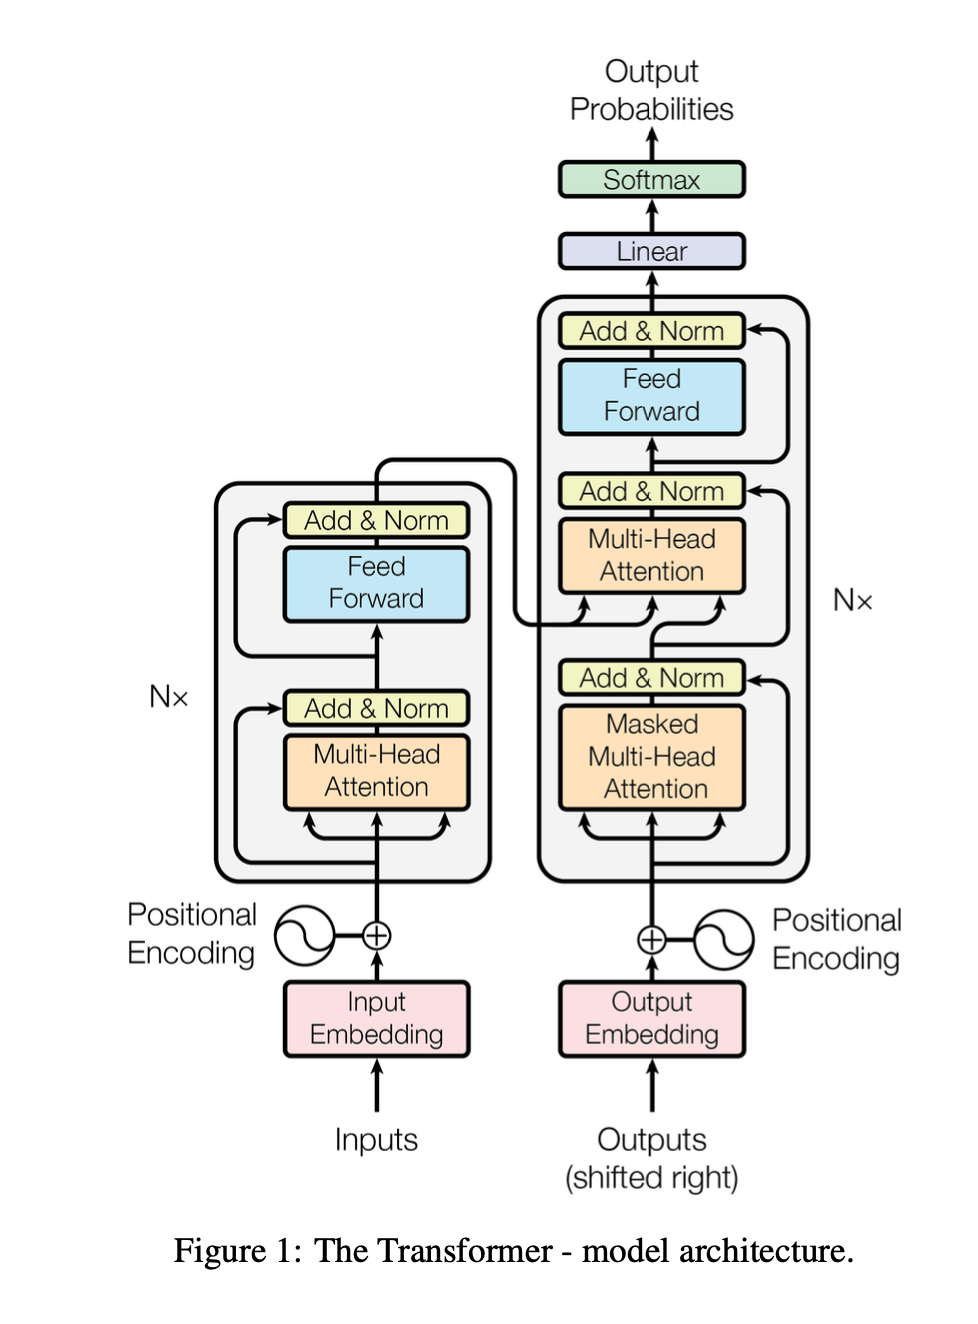

In [78]:
from IPython.display import Image
Image(filename='transformer.png', width=400)

## Single Head Attention Model

This is the bread and butter of the Transformer Model. This model is a single head attention model (also known as scaled dot-product attention or single-attention). This is the simplest form of the transformer model. The model is based on the idea of attention. Attention is a mechanism that allows the model to focus on certain parts of the input.

**Later on in the Notebook we have explained in depth how the attention mechanism works. Under the "Self-Attention Mechanism" section.**

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.val = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, is_masked=False):
        B, T, C = x.shape
        k = self.key(x) # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        
        # compute the attention weights
        weight = q @ k.transpose(-2, -1) / (C ** 0.5)  # (B, T, head_size) @ (B, head_size, T) --> (B, T, T)
        if is_masked:
            weight = weight.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # --> prevents attention to future tokens
        weight = F.softmax(weight, dim=-1)  # (B, T, T)  # --> normalizes the weights
        weight = self.dropout(weight)
        v = self.val(x) # (B, T, head_size)
        # print(weight.shape, v.shape)
        output = weight @ v # (B, T, T) @ (B, T, head_size) --> (B, T, head_size)
        return output  # --> (B, T, head_size)
        

## Cross Attention Model

Very similar to the SelfAttention class. However, the key and query come from the encoder and the value comes from the decoder. This is the cross-attention mechanism that allows the model to learn the relationship between the input and output data.

In [80]:
class CrossAttention(nn.Module):
    def __init__(self, head_size, key, val):
        super().__init()
        self.key = key
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.val = val

    def forward(self, x, is_masked=False):
        B, T, C = x.shape
        
        k = self.key(x) # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        
        # compute the attention weights
        weight = q @ k.transpose(-2, -1) / (C ** 0.5)
        if is_masked:
            weight = weight.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weight = F.softmax(weight, dim=-1)
        
        v = self.val(x)
        output = weight @ v
        return output

## Multi-Head Attention Model

This model uses the single self-attention model via loops. The model is able to focus on different parts of the input sequence.

In [81]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, is_cross_attention=False):
        super().__init__()
        if is_cross_attention:
            self.heads = nn.ModuleList([CrossAttention(head_size) for _ in range(num_heads)])  # --> creates a list of heads
        else:
            self.heads = nn.ModuleList([SelfAttention(head_size) for _ in range(num_heads)])  # --> creates a list of heads
        self.proj = nn.Linear(n_embd, n_embd)  # --> projects the concatenated heads to the original dimension
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, is_masked=False):
        output = torch.cat([h(x, is_masked) for h in self.heads], dim=-1)  # --> concatenates the output of each head, (B, T, num_heads * head_size)
        output = self.dropout(self.proj(output))  # --> linear transformation of the concatenated heads
        return output  # --> (B, T, C)

## Feed Forward Neural Network

In [82]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),  # Projection layer going back into residual pathway
            nn.Dropout(dropout),
        )
    
    def forward(self, x):
        return self.net(x)

## Decode and Encode Blocks

### Decoder

In [ ]:
class DecodeBlock(nn.Module):
    def __init__(self, n_embd, n_heads, key=None, val=None):
        super().__init__()
        head_size = n_embd // n_heads
        self.sa = MultiHeadAttention(n_heads, head_size)
        if((key is not None) and (val is not None)):
            self.ca = CrossAttention(n_heads, head_size, key, val)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)  
        self.ln3 = nn.LayerNorm(n_embd)  # --> for cross attention
        self.key = key
        self.val = val

    def forward(self, x, is_masked=False):
        # Residual connections (bc of the skip connection, the add) w/ layer normalization
        x = x + self.sa(self.ln1(x), is_masked=True)
        x = x + self.ca(self.ln3(x), self.key, self.val)  # --> for cross attention
        x = x + self.ffwd(self.ln2(x))
        return x

### Encoder

In [84]:
class EncodeBlock(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        head_size = n_embd // n_heads
        self.sa = MultiHeadAttention(n_heads, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    
    def forward(self, x):
        # Residual connections (bc of the skip connection, the add) w/ layer normalization
        x = x + self.sa(self.ln1(x), is_masked=False) 
        x = x + self.ffwd(self.ln2(x))
        return x
    

## Bigram Model

Our team decided to use a BigramLanguageModel because of it's simplicity. We understand that a bigram model is not the most accurate model, but we wanted to start with a simple model and then build on top of it. The bigram model only uses the previous word to predict the next word. However, we will be implementing a self-attention mechanism to improve the model and allow characters to have a context of more than just the previous character.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(seed)

class BigramLanguageModel(nn.Module):
    def __init__(self, v_size, key=None, val=None):
        super().__init__()
        # Embedding table that maps from indices to vectors of size n_embd
        self.token_embedding_table = nn.Embedding(v_size, n_embd)
        self.postion_encoding_table = nn.Embedding(block_size, n_embd)  # each position maps to a learnable embedding. now tokens know their position
        
        self.blocks = nn.Sequential(*[DecodeBlock(n_embd, n_heads, key, val) for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(n_embd)
        self.linear = nn.Linear(n_embd, v_size)  # token_embd -> logits over the vocabulary

    def forward(self, idx, targets=None):
        # NOTE: idx and targets are (B, T) tensors of ints
        B, T = idx.shape
        
        tok_embd = self.token_embedding_table(idx)  # (B, T, n_embd) (batch, time, channels), where C is the embedding size
        pos_embd = self.postion_encoding_table(torch.arange(T, device=device))  # (T, C)
        x = tok_embd + pos_embd  # (B, T, C)
        x = self.blocks(x)
        x = self.layer_norm(x)
        logits = self.linear(x)  # (B, T, vocab_size), this is the prediction for the next token in the sequence
        
        # compute the loss -> this is to eval the quality of the predictions from the model
        if targets is None:
            loss = None
        else: 
            B, T, C = logits.shape
            # Update dimensions of logits and targets to fit the loss function
            logits = logits.view(B * T, C)  # (B, T, C) -> (B * T, C)
            targets = targets.view(B * T)  # (B, T) -> (B * T)
            loss = F.cross_entropy(logits, targets)  # -> compares the predicted logits with the actual targets
        
        return logits, loss

    def generate(self, idx, max_gens=100):
        # idx is (B, T) 
        for _ in range(max_gens):
            idx_cond = idx[:, -block_size:]  # only last block_size tokens are used
            # get predictions
            logits, loss = self(idx_cond)
            # focus only on the last token/time step
            logits = logits[:, -1, :]  # (B, T, vocab_size) -> (B, vocab_size)
            # apply softmax for probabilities
            probs = F.softmax(logits, dim=-1)  # (B, vocab_size)
            # sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat([idx, idx_next], dim=1)  # (B, T+1)
        return idx

# The 0th index is the '\n' char
# print(encode('\n'))  # -> 0
# idx = torch.zeros((1, 1), dtype=torch.long)
# print(decode(model.generate(idx, max_gens=500))[0].tolist())

TypeError: BigramLanguageModel.__init__() missing 2 required positional arguments: 'key' and 'val'

### Same as the BigramLM Model, but with different architecture. Encoder piece (Left-side of the image)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(seed)

class ChadGPT(nn.Module):
    def __init__(self, v_size):
        super().__init__()
        # Embedding table that maps from indices to vectors of size n_embd
        self.token_embedding_table = nn.Embedding(v_size, n_embd)
        self.postion_encoding_table = nn.Embedding(block_size, n_embd)  # each position maps to a learnable embedding. now tokens know their position
        
        self.blocks = nn.Sequential(*[EncodeBlock(n_embd, n_heads) for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(n_embd)
        self.linear = nn.Linear(n_embd, v_size)  # token_embd -> logits over the vocabulary

    def forward(self, idx, targets=None):
        # NOTE: idx and targets are (B, T) tensors of ints
        B, T = idx.shape
        
        tok_embd = self.token_embedding_table(idx)  # (B, T, n_embd) (batch, time, channels), where C is the embedding size
        pos_embd = self.postion_encoding_table(torch.arange(T, device=device))  # (T, C)
        x = tok_embd + pos_embd  # (B, T, C)
        x = self.blocks(x)
        x = self.layer_norm(x)
        logits = self.linear(x)  # (B, T, vocab_size), this is the prediction for the next token in the sequence
        
        # compute the loss -> this is to eval the quality of the predictions from the model
        if targets is None:
            loss = None
        else: 
            B, T, C = logits.shape
            # Update dimensions of logits and targets to fit the loss function
            logits = logits.view(B * T, C)  # (B, T, C) -> (B * T, C)
            targets = targets.view(B * T)  # (B, T) -> (B * T)
            loss = F.cross_entropy(logits, targets)  # -> compares the predicted logits with the actual targets
        
        return logits, loss

    def generate(self, idx, max_gens=100):
        # idx is (B, T) 
        for _ in range(max_gens):
            idx_cond = idx[:, -block_size:]  # only last block_size tokens are used
            # get predictions
            logits, loss = self(idx_cond)
            # focus only on the last token/time step
            logits = logits[:, -1, :]  # (B, T, vocab_size) -> (B, vocab_size)
            # apply softmax for probabilities
            probs = F.softmax(logits, dim=-1)  # (B, vocab_size)
            # sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat([idx, idx_next], dim=1)  # (B, T+1)
        return idx

m = ChadGPT(v_size) # Character model
# m = ChadGPT(v_size_words) # Word model
model2 = m.to(device)
logits, loss = model2(xb, yb)
print(logits.shape)
print(loss) # -ln(1/v_size) = -ln(1/76) = 4.3307 and -ln(1/v_size_words) = -ln(1/11672) = 9.3636

# The 0th index is the '\n' char
# print(encode('\n'))  # -> 0
# idx = torch.zeros((1, 1), dtype=torch.long)
# print(decode(model2.generate(idx, max_gens=500))[0].tolist())

torch.Size([2048, 76])
tensor(4.4290, grad_fn=<NllLossBackward0>)


## Optimizer

We tested different optimizers and found that the AdamW optimizer worked the best for our model.

In [ ]:
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

## Training The Model

This is the training loop for the model.

In [ ]:
m = ChadGPT(v_size) # Character model
# m = ChadGPT(v_size_words) # Word model
model2 = m.to(device)
logits2, loss2 = model2(xb, yb)
# print(logits.shape)
# print(loss) # -ln(1/v_size) = -ln(1/76) = 4.3307 and -ln(1/v_size_words) = -ln(1/11672) = 9.3636

m = BigramLanguageModel(v_size, key, val) # Character model
# m = BigramLanguageModel(v_size_words) # Word model
model = m.to(device)
logits, loss = model(xb, yb)
# print(logits.shape)
# print(loss) # -ln(1/vocab_size) = -ln(1/76) = 4.3307

for steps in range(10000):
    # Log training loss
    if steps % eval_interval == 0:
        losses = estimate_loss()
        print(f"Step: {steps}, Train Loss: {losses['train']:.4f}, Val Loss: {losses['val']:.4f}")
    
    xb, yb = get_batch('train')
    
    logits, loss = model(xb, yb)
    logits_2, loss_2 = model2(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
# print(loss.item())
print(f"Step: {steps}, Train Loss: {losses['train']:.4f}, Val Loss: {losses['val']:.4f}")
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_gens=500)[0].tolist()))  # Character Decoding
# print(decode_word(model.generate(context, max_gens=500)[0].tolist()))  # Word Decoding

Step: 0, Train Loss: 4.4101, Val Loss: 4.4100
Step: 500, Train Loss: 2.5934, Val Loss: 2.5965
Step: 1000, Train Loss: 2.4573, Val Loss: 2.4555
Step: 1500, Train Loss: 2.3940, Val Loss: 2.3983
Step: 2000, Train Loss: 2.3476, Val Loss: 2.3538
Step: 2500, Train Loss: 2.3061, Val Loss: 2.3121
Step: 3000, Train Loss: 2.2678, Val Loss: 2.2663
Step: 3500, Train Loss: 2.2166, Val Loss: 2.2178
Step: 4000, Train Loss: 2.1665, Val Loss: 2.1765
Step: 4500, Train Loss: 2.1173, Val Loss: 2.1320
Step: 5000, Train Loss: 2.0915, Val Loss: 2.0968
Step: 5500, Train Loss: 2.0535, Val Loss: 2.0611
Step: 6000, Train Loss: 2.0203, Val Loss: 2.0294
Step: 6500, Train Loss: 1.9909, Val Loss: 2.0030
Step: 7000, Train Loss: 1.9674, Val Loss: 1.9784
Step: 7500, Train Loss: 1.9432, Val Loss: 1.9549
Step: 8000, Train Loss: 1.9254, Val Loss: 1.9314
Step: 8500, Train Loss: 1.9049, Val Loss: 1.9153
Step: 9000, Train Loss: 1.8882, Val Loss: 1.8907
Step: 9500, Train Loss: 1.8709, Val Loss: 1.8830
Step: 9999, Train Loss: 

## Self-Attention Mechanism

#### Communication mechanism where you have the number of nodes in a directed graph, where every node has some vector of info that gets to aggregate the info from all the other nodes that are pointing to it. The averages are calculated using matrix multiplication in order to get the node weights. 

However with this implementation of self-attention, there is no notion of space. Meaning that the nodes are not aware of the position of the other nodes in the sequence. 

**NOTE: This example is ONLY with the word level vocab.**

In [ ]:
torch.tril(torch.ones(3, 3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [ ]:
B, T, C = 4, 8, 2 # batch size, sequence length, number of channels
x = torch.randn(B, T, C)

# single head attention performs self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
val = nn.Linear(C, head_size, bias=False)
k = key(x)    # (B, T, head_size)
q = query(x)  # (B, T, head_size)

# the 'affinities' of each token with respect to all other tokens
# the higher the affinity, the more the token will be weighted
# this is very important for the model to learn dependencies between tokens, so they can talk to each other effectively
weight = q @ k.transpose(-2, -1) / head_size**0.5  # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)


# create lower traingular matrix that will be used as weights
# this is done so that the model does not cheat by looking at the future tokens, only the past tokens
tril = torch.tril(torch.ones(T, T))  # lower triangular matrix
# weight = torch.zeros((T, T))  # matrix starts with zero weights
weight = weight.masked_fill(tril == 0, float('-inf'))  # set the upper triangular part to -inf so future tokens don't talk to past tokens
weight = F.softmax(weight, dim=-1)  # normalize the weights

# matrix multiplication, the output is the weighted sum of the input
# output = weight @ x  # (B, T, T) @ (B, T, C) -> (B, T, C)
v = val(x)  # (B, T, head_size)
print(weight.shape, v.shape)
output = weight @ v  # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
output.shape 

torch.Size([4, 8, 8]) torch.Size([4, 8, 16])


torch.Size([4, 8, 16])

In [ ]:
weight[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0834, 0.9166, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0492, 0.8177, 0.1331, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1185, 0.6418, 0.2021, 0.0377, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0969, 0.4246, 0.1693, 0.0403, 0.2689, 0.0000, 0.0000, 0.0000],
        [0.1626, 0.2104, 0.1682, 0.1279, 0.1975, 0.1334, 0.0000, 0.0000],
        [0.1431, 0.1370, 0.1434, 0.1506, 0.1382, 0.1485, 0.1392, 0.0000],
        [0.1216, 0.0623, 0.0914, 0.1726, 0.0773, 0.1846, 0.1025, 0.1877]],
       grad_fn=<SelectBackward0>)

In [ ]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
weight = q @ k.transpose(-2, -1) * (head_size ** -0.5)

In [ ]:
k.var(), q.var(), weight.var()

(tensor(1.0143), tensor(1.0291), tensor(1.2112))

In [ ]:
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_gens=300)[0].tolist()))


Delpizy tetes at't cansin is sactidealy, thily tredioutledinal. Nnd It wegacte and wonck. She any if it of jung but you reand cofe of galh thy salls ore taite retth. So yard ast to ser sogor ithil mets fovermatnct. Actuo rinh and ish to sthet Negt to you'r cof gist acle. Ben I spaxt osacy, the ic a 


## GUI

In [ ]:

 
class InputEmbedding:
    def __init__(self):
        self.token_embedding_table = nn.Embedding(v_size, n_embd)
        self.position_embedding = nn.Embedding(block_size, n_embd)

        self.block = EncodeBlock()

        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.val = nn.Linear(n_embd, head_size, bias=False)


    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        # compute the attention weights
        weight = q @ k.transpose(-2, -1) / (k.shape[-1] ** 0.5)  # (B, T, C) @ (B, C, T) --> (B, T, T)
        weight = F.softmax(weight, dim=1)
        v = self.val(x) # (B, T, C)
        output = weight @ v # (B, T, T) @ (B, T, C) --> (B, T, C)
        return output

 
    def generate(self, idx, max_gens=100):
        # idx is (B, T) 
        for _ in range(max_gens):
            idx_cond = idx[:, -block_size:]  # only last block_size tokens are used
            # get predictions
            logits, loss = self(idx_cond)
            # focus only on the last token/time step
            logits = logits[:, -1, :]  # (B, T, vocab_size) -> (B, vocab_size)
            # apply softmax for probabilities
            probs = F.softmax(logits, dim=-1)  # (B, vocab_size)
            # sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat([idx, idx_next], dim=1)  # (B, T+1)
        return idx

In [ ]:
import json
jsonl_file = "output_qa_pairs.jsonl"

values = []

with open(jsonl_file, 'r') as file:
    # Update the existing vocabulary with unique characters from "key"
    for line in file:
        data = json.loads(line)
        if "key" in data:
            vocab += list(data["key"])  # Add characters in "key" to vocab

    # Remove duplicates and sort the vocab
    vocab = sorted(list(set(vocab)))
    # Reset file pointer to read the file again
    file.seek(0)

    # Extract values from each line
    for line in file:
        data = json.loads(line)  # Parse each line as JSON
        entry = []

        if "key" in data:
            entry.append(data["key"])
        if "query" in data:
            entry.append(data["query"])
        if "val" in data:
            entry.append(data["val"])
        values.append(entry)

# Define encode function based on the updated vocabulary
stoi = {c: i for i, c in enumerate(vocab)}
encode = lambda x: [stoi[c] for c in x if c in stoi]

# Encode the values list in place
for i, input in enumerate(values):
    values[i] = [encode(text) for text in input]

def get_shape(lst):
    if isinstance(lst, list):
        return [len(lst)] + get_shape(lst[0]) if lst else []
    return []

print("Shape of the list:", get_shape(values))

Shape of the list: [5274, 3, 2974]
